In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append('../')
sys.path.append('/usr/users/fsimone/tejaas')
import numpy as np
from utils import readgtf

geneinfo_dict = dict()
gencode_file = "/cbscratch/franco/datasets/GENCODE/gencode.v26.annotation.gtf.gz"
geneinfo = readgtf.gencode_v12(gencode_file, biotype = ["protein_coding", "lncRNA"])
for i,g in enumerate(geneinfo):
    geneinfo_dict[g.ensembl_id] = (i,g)

Mode v26


In [5]:
from utils import utils
import json
json_file = "../gtex_v8_metadata.json"
with open(json_file) as instream:
    gtex_meta = json.load(instream)
    
tissue_file = "/usr/users/fsimone/trans-eqtl-pipeline/analysis/plots/tissues.txt"
tissues, descriptions = utils.read_tissues(tissue_file)
tissue_names   = dict()
tissue_colors  = dict()
tissue_samples = dict()
for tshort, tfull in zip(tissues, descriptions):
    tissue_names[tshort] = tfull
    tissue_colors[tshort] = "#" + gtex_meta[tfull.replace(" ", "_")]["colorHex"]
    tissue_samples[tshort] = gtex_meta[tfull.replace(" ", "_")]["rnaSeqAndGenotypeSampleCount"]

In [20]:
import mpmath
import collections
mpmath.mp.dps = 50
def pvalue(x): return float(mpmath.log10(1 - 0.5 * (1 + mpmath.erf(x/mpmath.sqrt(2)))))

SNPRES_FIELDS = ['rsid', 'chrom', 'pos', 'logp', 'target', 'maf']
class SNPRes(collections.namedtuple('_SNPRes', SNPRES_FIELDS)):
    __slots__ = ()
    
def tejaas(filepath, mafcutoff=0.01):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            chrom = int(arr[1])
            pos   = int(arr[2])
            maf   = float(arr[3])
            if maf < mafcutoff or maf > (1-mafcutoff):
                continue
            q     = float(arr[4])
            mu    = float(arr[5])
            sigma = float(arr[6])
            p     = float(arr[7])
            if sigma == 0:
                continue
            logp  = np.log10(p) if p != 0 else pvalue( (q - mu) / sigma)
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, logp=-logp, maf=maf, target=None))
    return res

def tejaas_targets(filepath):
    res = collections.defaultdict(list)
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            geneid  = arr[0]
            snpid   = arr[1]
            res[snpid].append(geneid)
    return res

def tejaas_targets_lasso(filepath):
    res = collections.defaultdict(list)
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            geneid  = arr[1]
            snpid   = arr[0]
            res[snpid].append(geneid)
    return res

In [38]:
basedir = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_lncRNA_freeze/summary_5e-08"
lasso_basedir = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_lncRNA_freeze/lasso_targets"
basedirLD = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_lncRNA_freeze/summary_LD_5e-08"

SNPTARGET_FIELDS = ['rsid', 'targets', 'lasso_targets']
class SNPTargets(collections.namedtuple('_SNPTargets', SNPTARGET_FIELDS)):
    __slots__ = ()

tissue_gene_counts = dict()
tissue_targets    = collections.defaultdict(list) 
tissue_transeqtls = dict()
for t in tissues:
    targetgenes_file = os.path.join(basedir, t, "tejaas", "target_genes.txt")
    targetlasso_file = os.path.join(lasso_basedir, "target_genes_{:s}_knn.txt".format(t))
    transeqtl_file = os.path.join(basedir, t, "tejaas", "trans_eqtls.txt")
    
    if not os.path.exists(targetlasso_file):
        continue
    
    transeqtls = tejaas(transeqtl_file)
    tissue_transeqtls[t] = transeqtls
    
    targets       = tejaas_targets(targetgenes_file)
    targets_lasso = tejaas_targets_lasso(targetlasso_file)
    
    for s in transeqtls:
        tissue_targets[t].append(SNPTargets(rsid=s.rsid, targets=targets[s.rsid], lasso_targets=targets_lasso[s.rsid]))

In [39]:
print(tissue_targets.keys())

dict_keys(['as', 'av', 'ag', 'aa', 'ac', 'at', 'bam', 'ban', 'bca', 'bceh', 'bce', 'bco', 'bfr', 'bhi', 'bhy', 'bnu', 'bpu', 'bsp', 'bsu', 'br', 'ebv', 'fib', 'cols', 'colt', 'esog', 'esom', 'esomu', 'hlv', 'kc', 'liv', 'lu', 'msg', 'ms', 'nt', 'pit', 'snse', 'sse', 'si', 'spl', 'sto', 'thy'])


In [49]:
for t in tissues:
    if t not in tissue_targets:
        print(f"{t} not in targets")
    no0_targets = np.sum([len(x.targets) > 0 for x in tissue_targets[t]])
    no0_lasso_targets = np.sum([len(x.lasso_targets) > 0 for x in tissue_targets[t]])

    # print("nº of SNPs with > 0 targets: {:d}/{:d}".format(no0_targets, len(tissue_targets[t])))
    # print("nº of SNPs with > 0 lasso targets: {:d}/{:d}".format(no0_lasso_targets, len(tissue_targets[t])))
    print("{:s}\t{:d}\t{:d}".format(t, len(tissue_targets[t]),  int(len(tissue_targets[t])-no0_lasso_targets)))

as	1280	58
av	671	19
ag	349	2
aa	2615	8
ac	3479	4
at	920	26
bam	2598	22
ban	2064	13
bca	18	2
bceh	157	44
bce	49	12
bco	76	11
bfr	33	1
bhi	108	1
bhy	207	1
bnu	663	7
bpu	7	0
bsp	86	1
bsu	40	2
br	841	11
ebv	514	5
fib	390	5
cols	138	2
colt	2198	3
esog	30	6
esom	90	12
esomu	35	0
haa	0	0
hlv	437	9
kc	17	0
liv	83	0
lu	907	8
msg	4	0
ms	4827	1631
nt	1573	88
pan not in targets
pan	0	0
pit	11	0
snse	1411	4
sse	642	22
si	133	0
spl	5	2
sto	453	2
thy	2658	35
wb not in targets
wb	0	0
ov not in targets
ov	0	0
pro not in targets
pro	0	0
tes not in targets
tes	0	0
ut	0	0
va not in targets
va	0	0
bl not in targets
bl	0	0


# Load trans-eQTLs dosages and gene expression

In [6]:
from iotools.readRPKM import ReadRPKM
from utils.readvcf_snp import ReadVCF
from sklearn.decomposition import PCA

def knn_correction(expr, dosage, K):
    pca = PCA(n_components=min(expr.shape[0], expr.shape[1]))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = K
    gx_knn = np.zeros_like(expr)
    gt_knn = np.zeros_like(dosage)
    neighbor_list = list()

    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)
        # noisy_neighbors = np.random.choice(neighbors, size = int(2 * kneighbor / 3), replace = False)
        # noisy_neighbors = np.random.choice(neighbors, size = kneighbor, replace = True )
        noisy_neighbors = neighbors
        gt_knn[:, i] = dosage[:, i] - np.mean(dosage[:, noisy_neighbors], axis = 1)
        neighbor_list.append(neighbors)

    return gx_knn, gt_knn

t = "as"
vcf_file = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_0.01/GTEX_v8_2019-07-29_WGS_838Indiv_Freeze_NoMissingGT_SNPfilter_MAF0.01_chr{:d}.vcf.gz"
fam_file = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8.sample"
gx_file  = "/cbscratch/franco/trans-eqtl/new_preprocess_aug2019/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered"
gx_file_cclm  = "/cbscratch/franco/trans-eqtl/new_preprocess_aug2019/gtex_v8/expression/tmm/{:s}_tmm_cclm.txt.protein_coding_lncRNA_filtered"

rpkm = ReadRPKM(gx_file.format(t), "gtex", npca = 0)
expression = rpkm.expression
expr_donors = rpkm.donor_ids
gene_names = rpkm.gene_names


rpkm_cclm = ReadRPKM(gx_file_cclm.format(t), "gtex", npca = 0)
expression_cclm = rpkm_cclm.expression

chrm = 1
snplist = [x.rsid for x in tissue_transeqtls[t] if x.rsid.startswith("chr"+str(chrm)+"_")]
vcf = ReadVCF(vcf_file.format(chrm), snplist=snplist, samplefile=fam_file)
dosage = vcf.dosage
gt_donor_ids = vcf.donor_ids
snpinfo = vcf.snpinfo

all found!
GT Sample selection 838 samples were retained from a total of 838 samples


In [7]:
print(dosage.shape)
print(expression.shape)
print(expression_cclm.shape)

(51, 838)
(15761, 581)
(15761, 581)


In [29]:
def select_donors(vcf_donors, expr_donors):
    ''' Make sure that donors are in the same order for both expression and genotype
    '''
    common_donors = [x for x in vcf_donors if x in expr_donors]
    vcfmask = np.array([vcf_donors.index(x) for x in common_donors])
    exprmask = np.array([expr_donors.index(x) for x in common_donors])
    return vcfmask, exprmask

def select_genes(info, names):
    ''' Select genes which would be analyzed. 
        Make sure the indices are not mixed up
    '''
    allowed = [x.ensembl_id for x in info]
    common  = [x for x in names if x in allowed]
    genes = [x for x in info if x.ensembl_id in common]
    indices = [names.index(x.ensembl_id) for x in genes]
    return genes, np.array(indices)

def normalize_and_center_dosage(dosage, snpinfo):
    f = [snp.maf for snp in snpinfo]
    f = np.array(f).reshape(-1, 1)
    gtnorm = (dosage - (2 * f)) / np.sqrt(2 * f * (1 - f))
    gtcent = dosage - np.mean(dosage, axis = 1).reshape(-1, 1)
    return gtnorm, gtcent #rr uses gtcent

vcfmask, exprmask = select_donors(gt_donor_ids, expr_donors)
genes, indices = select_genes(geneinfo, gene_names) 

expr_cclm = expression_cclm[:, exprmask]
expr      = expression[:, exprmask]
gt        = dosage[:, vcfmask]

gx_corr, gt_corr = knn_correction(expr.T, gt, K=30)
gx_corr_norm = rpkm._normalize_expr(gx_corr.T)
gt_corr_norm, gt_corr_cent = normalize_and_center_dosage(gt_corr, snpinfo)

gt_norm, gt_cent = normalize_and_center_dosage(gt, snpinfo)

gx_cclm_corr, gt_cclm_corr = knn_correction(expr_cclm.T, gt, K=30)
gx_cclm_corr_norm = rpkm._normalize_expr(gx_cclm_corr.T)
gt_cclm_corr_norm, gt_cclm_corr_cent = normalize_and_center_dosage(gt_cclm_corr, snpinfo)

In [12]:
def reshape_masked_betas(b, mask, ngenes):
    _b = b.reshape(1, ngenes-len(mask.rmv_id))
    paddedBeta = np.zeros( (1, ngenes) )
    inv_ind = np.delete(np.arange(ngenes), mask.rmv_id)
    paddedBeta[:, inv_ind] = _b
    return paddedBeta.reshape(-1)

In [18]:
def write_target_genes(filehandle, rsid, target_genes):
    line = "{:s}\t{:s}\t{:g}\n"
    for b, g in target_genes:
        filehandle.write(line.format(rsid, g.ensembl_id, b))
        
def RR_Lasso(gx, gt, geneinfo, snp, filehandle):
    lm = linear_model.LassoCV()
    lm.fit(gx.T, gt)
    reg_score = lm.score(gx.T, gt)
    print("Score: {:g}".format(reg_score))
    betas_reshape = reshape_masked_betas(lm.coef_, mask, EXPR.shape[0])
    target_gene_inds = np.where(np.abs(betas_reshape) > 0)
    target_genes = [(betas_reshape[j], geneinfo[j]) for j in target_gene_inds[0]]
    write_target_genes(outknn, snp.varid, target_genes)
    return target_genes

In [58]:
from sklearn import linear_model
EXPR  = gx_corr_norm
EXPR2 = gx_cclm_corr_norm# expr_cclm

outknn  = open("target_genes_{:s}_knn.txt".format(t), 'w') 
# outcclm = open("target_genes_{:s}_cclm.txt".format(t), 'w') 
for mask in cismaskcomp:
    usegenes = np.ones(EXPR.shape[0], dtype=bool)
    if mask.rmv_id.shape[0] > 0: usegenes[mask.rmv_id] = False
    gx_masked      = EXPR[usegenes]
    gx_masked_cclm = EXPR2[usegenes]
    for i in mask.apply2:
        GT1 = gt_corr_cent[i,:]
        GT2 = gt_cclm_corr_cent[i,:]
        targets1 = RR_Lasso(gx_masked, GT1, genes, snpinfo[i], outknn)      
        # targets2 = RR_Lasso(gx_masked_cclm, GT2, genes, snpinfo[i], outcclm)      
outknn.close()
# outcclm.close()
        

/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.8462


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.922157


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.327757


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.999936
Score: 0.377597


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.989924


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.889951


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.972323


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.99766


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.0603233


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.287191


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.969684


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.745246


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.764054


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.940979


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.99997
Score: 0.976198


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.980228


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.999986
Score: 0.793465


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.892252


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.00658173


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.545328


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.634393


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.843266


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.910106


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.672729


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.343972


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.247109


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.539364


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.0529472


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.510266


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.56667


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.939329


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.550679


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.211422


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.239468


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.302197


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.271846


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.876564


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.0461355


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.517336


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.0917697


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.631509


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.821477


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.10715


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.315099


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.999554


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.997636


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Score: 0.0362304


In [ ]:
lasso_knn_targets   = [g.ensembl_id for i,g in targets1]
lasso_cclm_targets  = [g.ensembl_id for i,g in targets2]
tejaas_targets = [g for s,g in tissue_targets[t] if s == snpinfo[0].varid]

common_knn  = set.intersection(set(lasso_knn_targets), set(tejaas_targets))
common_cclm = set.intersection(set(lasso_cclm_targets), set(tejaas_targets))
common_knn_cclm = set.intersection(set(lasso_knn_targets), set(lasso_cclm_targets))

In [ ]:
print(common_knn)
print(common_cclm)
print(len(lasso_knn_targets), len(lasso_cclm_targets), len(common_knn))

In [24]:
print(len(common_knn))

90


In [54]:
ind = [i for i,e in enumerate(genes) if e.ensembl_id == "ENSG00000169291.9"]

In [55]:
snpinfo[0]

SnpInfo(chrom=1, varid='chr1_1170732_A_G_b38', bp_pos=1170732, ref_allele='A', alt_allele='G', maf=0.10560859188544153)

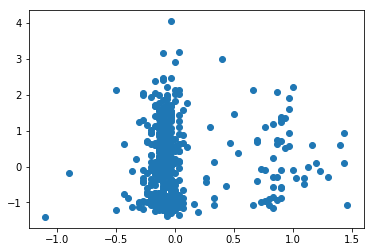

In [56]:
import matplotlib.pyplot as plt

plt.scatter(GT1, EXPR[ind,:])
plt.show()

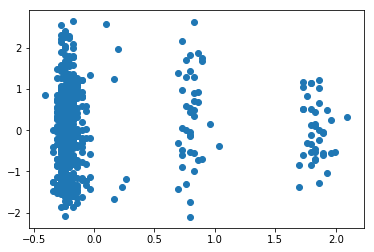

In [57]:

plt.scatter(GT2, EXPR2[ind,:])
plt.show()

In [ ]:
## It works
# masked_geneinfo = [g for i,g in enumerate(geneinfo) if i not in mask.rmv_id]
# target_gene_inds = np.where(np.abs(betas) > 0)
# [masked_geneinfo[i] for i in target_gene_inds[0]]

In [ ]:
print(len(gene_names))
tcounts = list()
for g in gene_names:
    tcounts.append(tissue_gene_counts[tissues[0]][g])

In [ ]:
tissue_gene_counts[tissues[0]]

In [ ]:
np.histogram(tcounts, bins=100)